In [1]:
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import colorsys

import matplotlib.cm as cmx
import os
import glob

In [2]:
c_Norm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('cool'))

In [3]:
def plot_one_proc(tau_lst, q_proc, ax, label_on):
    for idx, q in enumerate(q_proc):
        colorVal = scalarMap.to_rgba(tau_lst[idx])
        lb = str(+tau_lst[idx])+'-quantile' if label_on else ''
        ax.plot(q, color=colorVal, label=lb)  

# fig, ax = plt.subplots(1,1)
# plot_one_proc(tau_vals, sgd_proc, ax, True)

In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
#     import matplotlib.colors as mc
    try:
        c = colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_procs_error_bar(ax, tau_lst, q_true, q_procs, Frugal):
    N_dim = len(q_procs.shape)
    if q_true is not None:
        if (len(q_true.shape)==2 and q_true.shape[0] !=1 and q_true.shape[1] !=1):
            q_true = q_true.mean(axis=0)
        for idx, qt in enumerate(q_true):
            colorVal = scalarMap.to_rgba(tau_lst[idx])                
            ax.axhline(qt, linestyle='--', color=colorVal, label=(str(tau_lst[idx])+'-q true'))
            
    if N_dim == 2:
        plot_one_proc(tau_lst, q_procs, ax, True)
            
    elif N_dim == 3: 
        proc_mean = np.mean(q_procs, 0)
        proc_max = np.max(q_procs, 0) - proc_mean
        proc_min = proc_mean - np.min(q_procs, 0) 
        
        for i in range(len(tau_lst)):
            
            err = np.vstack((proc_max[i], proc_min[i]))
            colorVal = scalarMap.to_rgba(tau_lst[i])
            ax.errorbar(np.arange(proc_mean.shape[-1]),
                        proc_mean[i], 
                        yerr=err, ecolor = lighten_color(colorVal, 0.4),
                        color=colorVal, 
                        label = str(tau_lst[i])+'-q'+(' Frugal' if Frugal else ' SGD'))

    ax.set_xlabel('Number of Samples')

    

def plot_procs(ax_name, tau_lst, q_true, q_procs, q_compare=None):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    
    plot_procs_error_bar(ax, tau_lst, q_true, q_procs, (q_compare is not None))
    
    if q_compare is not None:
        for idx, proc in enumerate(q_compare):
            colorVal = scalarMap.to_rgba(tau_lst[idx])
            ax.plot(proc, color = lighten_color(colorVal, 1.6),
                   label = str(tau_lst[idx])+'-q SGD')
    
    lgd = ax.legend(loc='right', bbox_to_anchor=(0.65, -0.25),
    frameon=False, ncol=(3 if ((q_true is not None) and (q_compare is not None)) else 2))
    ax.set_title(ax_name)
    ax.set_ylabel('Quantile Value')

    return fig, lgd


# _, compare_proc = get_q_ests(dataset, '2_div_sqrt_k', tau_vals)

# plot_procs('ax_name', tau_vals, q_batches, sgd_proc)

In [5]:
def plt_stripe(tau_lst, ax, q_lst, pattern, name, hist_on):
#     hist_on = (len(q_lst.shape) > 2)
    q_lst = q_lst.T
    for idx, q in enumerate(q_lst):
        colorVal = scalarMap.to_rgba(tau_lst[idx])
        lb = str(+tau_lst[idx])+name
        if not hist_on:
            line = ax.plot([q,q], [0,1], pattern, color=colorVal)
            line[0].set_label(lb)
        else:
            bins = 10
            line = ax.hist(q.reshape(-1), bins, color=colorVal, label=lb)

def plot_spectrum_stripes(ax_name, q_lst, q_batches, q_sgd_res):
    c_Norm = colors.Normalize(vmin=0, vmax=1)
#     scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('cool'))
    styles = ['-', '--']
    names = ['-q batch', '-q sgd   ']
    
    fig = plt.figure(figsize=(16,4))
    ax_batch = fig.add_subplot(211)
    ax_sgd = fig.add_subplot(212, sharex = ax_batch)
    
    
    plt_stripe(q_lst, ax_batch, q_batches, styles[0], names[0], False)
    plt_stripe(q_lst, ax_sgd, q_sgd_res, styles[1], names[1], False)

    #set 
    ax_batch.set_xlabel('batch value')
    ax_batch.xaxis.set_label_coords(0.04, 0.98)
    ax_batch.set_yticks([])
    ax_batch.set_title(ax_name)

    plt.locator_params(axis='x', nbins=10)

    ax_sgd.set_xlabel('sgd value')
    ax_sgd.xaxis.set_label_coords(0.035, 0.98)
    ax_sgd.set_yticks([])

    # set position of legend
    ax_batch.legend(loc='lower center', bbox_to_anchor=(0.5, -1.8),
            frameon=False, ncol=len(q_lst))
    lgd = ax_sgd.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8),
        frameon=False, ncol=len(q_lst))
        
    return fig, lgd       

# plot_spectrum_stripes('ax name', tau_vals, q_batches, sgd_res)

In [6]:
from matplotlib.ticker import PercentFormatter

def plot_E_res(ax_name, tau_lst, e):
    e = e.T
    if len(e.shape)>2: raise Exception('E shape is too high!')
    fig, axes = plt.subplots(nrows=len(tau_lst), sharex=True)
    fig.set_size_inches(14, 8)
    for i, ax in enumerate(axes):
        if i==0: ax.set_title(ax_name)
        if i==len(tau_lst)-1: ax.set_title('Error value', y=-0.5)
        colorVal = scalarMap.to_rgba(tau_lst[i])
        ax.hist(e[i], weights=np.ones(len(e[i]))/len(e[i]), bins=10, color=colorVal)
        ax.plot([e[i].mean(), e[i].mean()], [0,1], color='black')
        ax.set_xlabel((str(tau_lst[i])+'-quantile'))
        ax.xaxis.set_label_coords(0.95, 0.97)
        ax.yaxis.set_major_formatter(PercentFormatter(1))
#         ax.plot([e[i].mean(), e[i].mean()], [0,1], color='black')
    fig.suptitle('Histogram for Error Values', y = 0.94)
    return fig
# plot_E_res('axname', tau_vals, E)

In [7]:
def read_data_file(file):
    with open (file) as f:
        s = f.readline()[16:-2]
        shape = tuple(int(i) for i in s.split(","))
        data = np.reshape(np.loadtxt(f), shape)
    return data
    
def read_overview(overview):
    with open(overview) as f:
        ax_name = f.readline()[:-1]
        tau_lst = list(float(i) for i in f.readline()[1:-1].split(','))
    return ax_name, tau_lst


In [8]:
folder_name = "Experiment_results/SGD/distro/exp_"

def plot_charts_one_setting(folder_name):
#     print (folder_name+"overview.txt")
    ax_name, tau_lst = read_overview(folder_name+"overview.txt")
    file_name = folder_name[:-1]
#     print(file_name)
    
    # stripe plots ---------------
    q_batches = read_data_file(folder_name+"q_batches"+".txt")
    sgd_res = read_data_file(folder_name+"q_est_res"+".txt")

    fig_res, lgd_res = plot_spectrum_stripes(ax_name, tau_lst, q_batches, sgd_res)
    title = fig_res.suptitle('Batch vs SGD quantile results')
    plt.savefig(file_name+"_res.png", bbox_extra_artists=[lgd_res, fig_res], bbox_inches='tight')
    
    
    
    # proc plots -----------------
    q_true = read_data_file(folder_name+"q_true"+".txt")
    sgd_proc = read_data_file(folder_name+"q_est_proc"+".txt")
    fig_proc, lgd_proc = plot_procs(ax_name, tau_lst, q_true, sgd_proc)
    fig_proc.suptitle('SGD Quantile Estimation Processes')
    plt.savefig(file_name+"_proc.png", bbox_extra_artists=[lgd_proc, fig_proc], bbox_inches='tight')
    
    
    # error plots ----------------
    e = read_data_file(folder_name+"E"+".txt")
    fig_err = plot_E_res(ax_name, tau_lst, e)
    plt.savefig(file_name+"_err.png")
    
# plot_charts_one_setting(folder_name)

In [9]:
def plot_charts(folder_name):
    for folder in os.listdir(folder_name):
        for f in glob.glob(os.path.join((folder_name+folder), "*_overview.txt")):
            print (f[:-len("overview.txt")])
            single_setting = f[:-12]
            plot_charts_one_setting(single_setting)

In [10]:
def plot_charts_one_folder(folder_name):
    folder = ''
    for f in glob.glob(os.path.join((folder_name+folder), "*_overview.txt")):
        print (f[:-len("overview.txt")])
        single_setting = f[:-12]
        plot_charts_one_setting(single_setting)

Experiment_results/Adaptive_stepsize/data_size/10000_
Experiment_results/Adaptive_stepsize/data_size/1000_


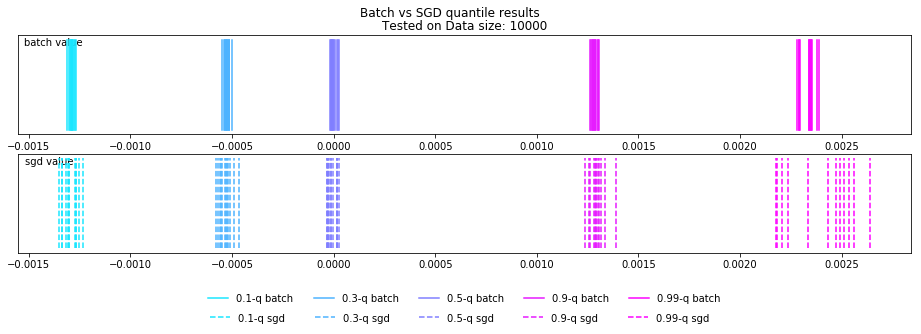

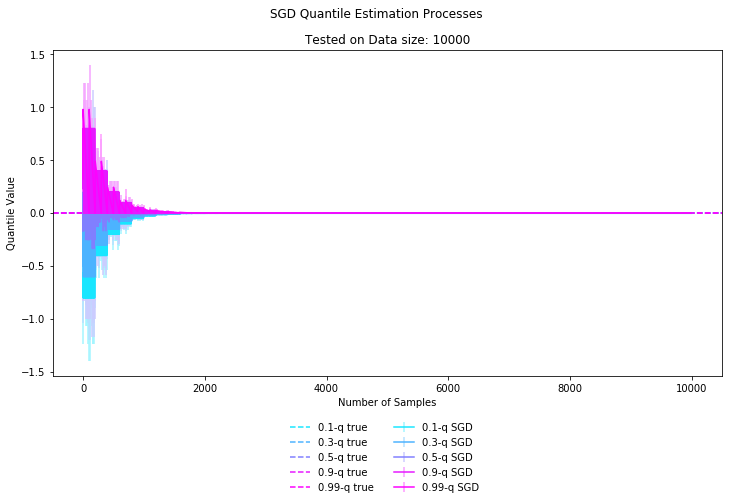

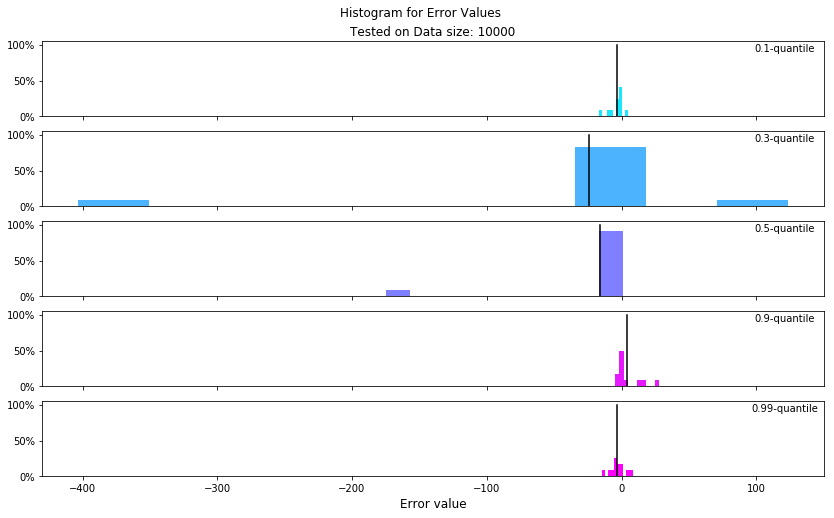

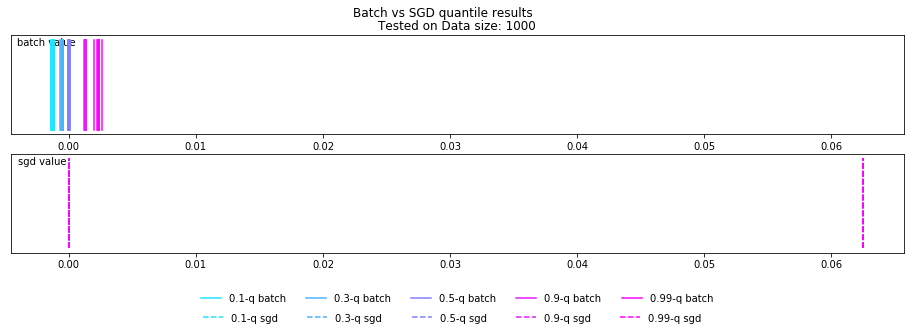

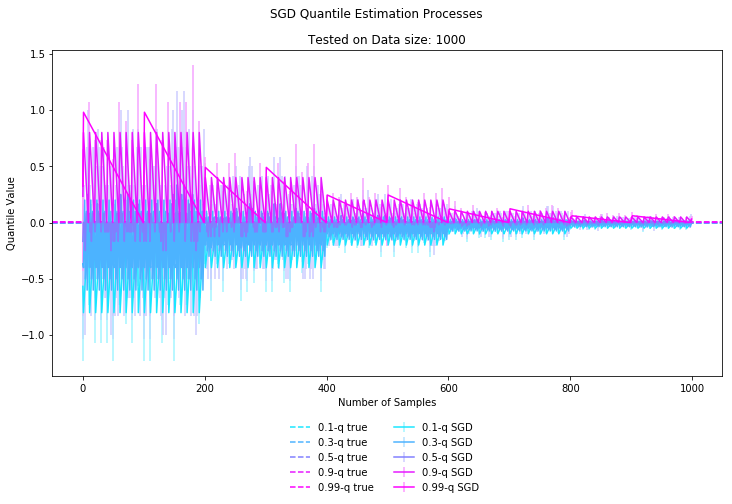

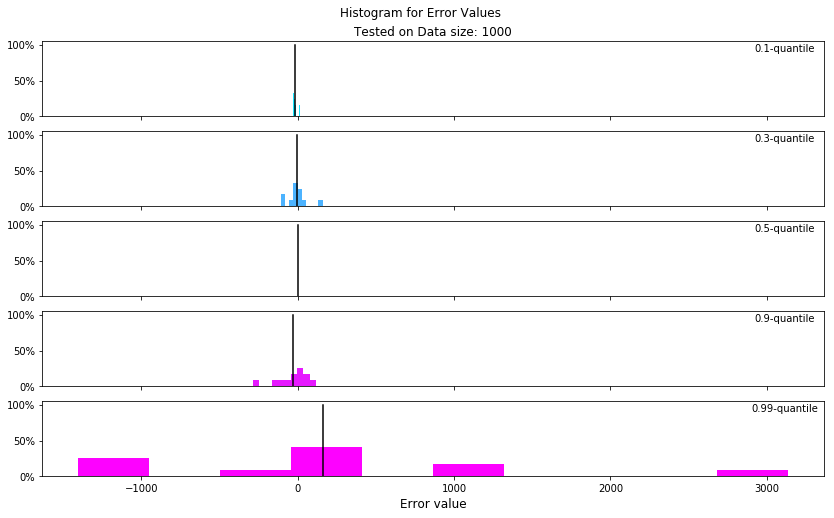

In [14]:
# plot_charts("Experiment_results/SGD/")
# plot_charts_one_folder("Experiment_results/SGD/step_size/")
# Adaptive_stepsize
# plot_charts("Experiment_results/Adaptive_stepsize/")
plot_charts_one_folder("Experiment_results/Adaptive_stepsize/data_size/")
